# Multiclass Semantic Segmentation using CamVid dataset

## Introduction
- Semantic Segmentation of an image is to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification.
- A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network. - - The encoder is usually is a pre-trained classification network like VGG/ResNet followed by a decoder network. The decoder network/mechanism is mostly where these architectures differ. 
- The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. (mechanisms like skip connections, pyramid pooling etc are used for this)



## Importing libraries

In [46]:
#!pip install tensorflow-gpu==2.0.0-alpha0

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Environment checks

In [48]:
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [49]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [50]:
print(tf.executing_eagerly())

True


In [51]:
setup_data = 0

In [52]:
import shutil


## Try to remove tree; if failed show an error using try...except on screen
#shutil.rmtree("data/CamSeq01/train_frames")
#shutil.rmtree("data/CamSeq01/train_masks")
#shutil.rmtree("data/CamSeq01/val_frames")
#shutil.rmtree("data/CamSeq01/val_masks")

In [53]:
if setup_data == 1:
  !wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip

In [54]:
if setup_data == 1:
  !mkdir data
  !mkdir data/CamSeq01

In [55]:
if setup_data == 1:
  !unzip CamSeq01.zip -d data/CamSeq01

## Data preparation - Importing, Cleaning and Creating structured directory 

### Function to import and process frames and masks as tensors

In [56]:
#HM
# local library
import rgb_lab_formulation as Conv_img

def _read_to_tensor(fname, output_height=1120, output_width=1504, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    
    #HM 
    # convert to lab-space image {L, a, b}
    # lab = Conv_img.rgb_to_lab(output)
    # L_chan, a_chan, b_chan = Conv_img.preprocess_lab(lab)
    # lab = Conv_img.deprocess_lab(L_chan, a_chan, b_chan)
    #HM
    # get back the RGB image
    # true_image = Conv_img.lab_to_rgb(lab)
    # output = tf.image.convert_image_dtype(true_image, dtype=tf.uint8, saturate=True)
    
    return output

def _read_to_tensor_mask(fname, output_height=1120, output_width=1504, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
        
    return output

### Image directory and size parameters

In [57]:
img_dir = 'data_white/'

# Required image dimensions
output_height = 1120
output_width = 1504

### Reading frames and masks
- Mask file names end in "\_L.png"


In [58]:
def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    file_list.sort()
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('png' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('png' in file) and ('txt' not in file)]
    
    frames_list.sort()
    masks_list.sort()
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor_mask)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list

frame_tensors, masks_tensors, frames_list, masks_list = read_images(img_dir)

1378 frame files found in the provided directory.
1378 mask files found in the provided directory.
Completed importing 1378 frame images from the provided directory.
Completed importing 1378 mask images from the provided directory.


### Displaying Images in the train dataset

(1120, 1504, 3)


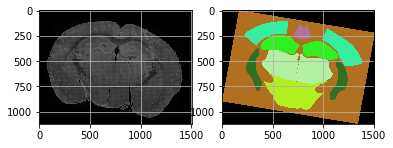

(1120, 1504, 3)


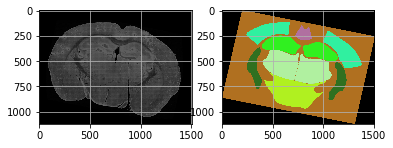

(1120, 1504, 3)


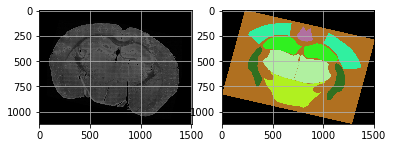

(1120, 1504, 3)


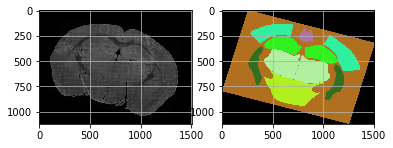

(1120, 1504, 3)


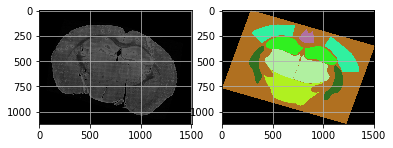

In [59]:
# Make an iterator to extract images from the tensor dataset

frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    print(shape(mask))
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.grid(b=None)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.grid(b=None)
    plt.imshow(mask)
    plt.show()

### Creating folder structure common for Computer Vision problems

In [60]:
DATA_PATH = 'data_white/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[Errno 17] File exists: 'data_white/CamSeq01/train_frames/train'
[Errno 17] File exists: 'data_white/CamSeq01/train_masks/train'
[Errno 17] File exists: 'data_white/CamSeq01/val_frames/val'
[Errno 17] File exists: 'data_white/CamSeq01/val_masks/val'


### Saving frames and masks to correct directories

In [61]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
#generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

## Extract Target Class definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [62]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [63]:
label_codes = [(176,112,32),(176,240,32),(48,112,32),(112,112,32),(48,240,32),(176,240,160),(176,112,160),(48,112,160),(48,240,160),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40)]
label_names = ['Cortical subplate','Hypothalamus','Cerebral nuclei','auditory area','Hippocampal formation','Thalamus','Retrosplenial area','Olfactory area','Somatosensory area','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump']


#label_codes = [(255,128,0),(181,230,29),(0,0,0),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),]
#label_names = ['Crinoid','back','black','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump']
label_codes[:5], label_names[:5]

([(176, 112, 32),
  (176, 240, 32),
  (48, 112, 32),
  (112, 112, 32),
  (48, 240, 32)],
 ['Cortical subplate',
  'Hypothalamus',
  'Cerebral nuclei',
  'auditory area',
  'Hippocampal formation'])

In [64]:
label_codes, label_names

([(176, 112, 32),
  (176, 240, 32),
  (48, 112, 32),
  (112, 112, 32),
  (48, 240, 32),
  (176, 240, 160),
  (176, 112, 160),
  (48, 112, 160),
  (48, 240, 160),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40),
  (50, 50, 40)],
 ['Cortical subplate',
  'Hypothalamus',
  'Cerebral nuclei',
  'auditory area',
  'Hippocampal formation',
  'Thalamus',
  'Retrosplenial area',
  'Olfactory area',
  'Somatosensory area',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump',
  'dump'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [65]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [66]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [67]:
id2code

{0: (176, 112, 32),
 1: (176, 240, 32),
 2: (48, 112, 32),
 3: (112, 112, 32),
 4: (48, 240, 32),
 5: (176, 240, 160),
 6: (176, 112, 160),
 7: (48, 112, 160),
 8: (48, 240, 160),
 9: (50, 50, 40),
 10: (50, 50, 40),
 11: (50, 50, 40),
 12: (50, 50, 40),
 13: (50, 50, 40),
 14: (50, 50, 40),
 15: (50, 50, 40),
 16: (50, 50, 40),
 17: (50, 50, 40),
 18: (50, 50, 40),
 19: (50, 50, 40),
 20: (50, 50, 40),
 21: (50, 50, 40),
 22: (50, 50, 40),
 23: (50, 50, 40),
 24: (50, 50, 40),
 25: (50, 50, 40),
 26: (50, 50, 40),
 27: (50, 50, 40),
 28: (50, 50, 40),
 29: (50, 50, 40),
 30: (50, 50, 40),
 31: (50, 50, 40)}

In [68]:
id2name

{0: 'Cortical subplate',
 1: 'Hypothalamus',
 2: 'Cerebral nuclei',
 3: 'auditory area',
 4: 'Hippocampal formation',
 5: 'Thalamus',
 6: 'Retrosplenial area',
 7: 'Olfactory area',
 8: 'Somatosensory area',
 9: 'dump',
 10: 'dump',
 11: 'dump',
 12: 'dump',
 13: 'dump',
 14: 'dump',
 15: 'dump',
 16: 'dump',
 17: 'dump',
 18: 'dump',
 19: 'dump',
 20: 'dump',
 21: 'dump',
 22: 'dump',
 23: 'dump',
 24: 'dump',
 25: 'dump',
 26: 'dump',
 27: 'dump',
 28: 'dump',
 29: 'dump',
 30: 'dump',
 31: 'dump'}

### Define functions for one hot encoding rgb labels, and decoding encoded predictions

In [69]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating custom Image data generators

### Defining data generators

In [70]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255, brightness_range=[0.6,1.4], horizontal_flip=False)
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)
test_frames_datagen = ImageDataGenerator(**data_gen_args)
test_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [71]:
def TrainAugmentGenerator(seed = 1, batch_size = 5):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 5):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        
def TestAugmentGenerator(seed = 1, batch_size = 10):
    '''Test Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    test_image_generator = test_frames_datagen.flow_from_directory(
    DATA_PATH + 'test_frames/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    test_mask_generator = test_masks_datagen.flow_from_directory(
    DATA_PATH + 'test_masks/',
    batch_size = batch_size, seed = seed, target_size = (224, 224))


    while True:
        X1i = test_image_generator.next()
        X2i = test_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)        


# Defining FCN-32 model for semantic segmentation
<b>FCN-32 Architecture</b>

<div style="text-align: center;">
        
        <img src="http://deeplearning.net/tutorial/_images/fcn.png" alt="FCN-32"U height="600" width="800">
</div>

[Picture Credits](http://deeplearning.net/tutorial/fcn_2D_segm.html)<br><br>


In [72]:
#from tqdm import tqdm

In [73]:
#from tqdm import tqdm_gui

In [74]:
os.getcwd()

'/home/mirap/tensorflowGUI/alpha/Multiclass-Semantic-Segmentation-CamVid'

In [75]:

#os.getcwd()
#!mkdir pretrained_weights

In [76]:
#!wget -O pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5  https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

### Function to create FCN-32 model, using VGG-16 pre-trained weights

In [77]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


import os

VGG_Weights_path = "pretrained_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

IMAGE_ORDERING = 'channels_last'


def FCN32( n_classes ,  input_height=224, input_width=224 , vgg_level=3):

    assert input_height%32 == 0
    assert input_width%32 == 0

    # https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5
    img_input = Input(shape=(input_height,input_width,3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
    f5 = x

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense( 1000 , activation='softmax', name='predictions')(x)

    vgg  = Model(  img_input , x  )
    vgg.load_weights(VGG_Weights_path)

    o = f5

    o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)
    o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    o = ( Conv2D( n_classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    o = Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(32,32) , use_bias=False ,  data_format=IMAGE_ORDERING )(o)
    #o_shape = Model(img_input , o ).output_shape

    #outputHeight = o_shape[2]
    #outputWidth = o_shape[3]

    #print ("koko" , o_shape)

    #o = (Reshape(( -1  , outputHeight*outputWidth   )))(o)
    #o = (Permute((2, 1)))(o)
    o = (Activation('softmax'))(o)
    model = Model( img_input , o )
    #model.outputWidth = outputWidth
    #model.outputHeight = outputHeight

    return model


In [78]:
model = FCN32( 32 ,  input_height=224, input_width=224 , vgg_level=3)


In [79]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Defining twerky loss and dice co-efficients for model performance

In [80]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


In [81]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [82]:
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) - intersection + smooth)

In [83]:
smooth = 1.

In [84]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))),
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [85]:
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,recall,precision,iou,'accuracy'])
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),iou,'accuracy'])


In [86]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [87]:
 model.load_weights("camvid_model_FCN32_whitehole.h5")

## Define model callback settings

In [88]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_FCN32_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=50, verbose=1)
callbacks = [tb, mc, es]

## Train and save the U-Net model

In [89]:
batch_size = 5
steps_per_epoch = np.ceil(float(len(frames_list) - round(0.2*len(frames_list))) / float(batch_size))
steps_per_epoch

221.0

In [90]:
validation_steps = (float((round(0.2*len(frames_list)))) / float(batch_size))
validation_steps

55.2

In [121]:
num_epochs = 100

In [49]:
# Train model

batch_size = 5
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=steps_per_epoch,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks,
                use_multiprocessing=False, verbose=1)
model.save_weights("camvid_model_FCN32_v1_BC_e100.h5", overwrite=True)

Epoch 1/100
Found 1218 images belonging to 1 classes.
Found 1218 images belonging to 1 classes.
243/244 [============================>.] - ETA: 0s - loss: 0.2710 - tversky_loss: 31.3256 - dice_coef: 0.7412 - recall: 0.8325 - precision: 0.6381 - iou: 0.5904 - acc: 0.8876Found 294 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
244/244 [==============================] - 243s 995ms/step - loss: 0.2710 - tversky_loss: 31.3259 - dice_coef: 0.7408 - recall: 0.8324 - precision: 0.6378 - iou: 0.5899 - acc: 0.8876 - val_loss: 0.2914 - val_tversky_loss: 31.3183 - val_dice_coef: 0.7445 - val_recall: 0.8383 - val_precision: 0.6415 - val_iou: 0.5946 - val_acc: 0.8899
Epoch 2/100
244/244 [==============================] - 234s 959ms/step - loss: 0.2491 - tversky_loss: 31.3119 - dice_coef: 0.7503 - recall: 0.8469 - precision: 0.6455 - iou: 0.6018 - acc: 0.8960 - val_loss: 0.2730 - val_tversky_loss: 31.3068 - val_dice_coef: 0.7538 - val_recall: 0.8532 - val_precision: 0.6504 - 

244/244 [==============================] - 236s 967ms/step - loss: 0.1298 - tversky_loss: 31.2339 - dice_coef: 0.8011 - recall: 0.9247 - precision: 0.6923 - iou: 0.6698 - acc: 0.9459 - val_loss: 0.2746 - val_tversky_loss: 31.2696 - val_dice_coef: 0.7675 - val_recall: 0.8792 - val_precision: 0.6585 - val_iou: 0.6241 - val_acc: 0.9129
Epoch 11/100
244/244 [==============================] - 237s 970ms/step - loss: 0.1249 - tversky_loss: 31.2305 - dice_coef: 0.8032 - recall: 0.9276 - precision: 0.6943 - iou: 0.6726 - acc: 0.9479 - val_loss: 0.2820 - val_tversky_loss: 31.2717 - val_dice_coef: 0.7642 - val_recall: 0.8760 - val_precision: 0.6543 - val_iou: 0.6194 - val_acc: 0.9104
Epoch 12/100
244/244 [==============================] - 237s 971ms/step - loss: 0.1199 - tversky_loss: 31.2274 - dice_coef: 0.8051 - recall: 0.9307 - precision: 0.6964 - iou: 0.6754 - acc: 0.9500 - val_loss: 0.2724 - val_tversky_loss: 31.2639 - val_dice_coef: 0.7717 - val_recall: 0.8855 - val_precision: 0.6633 - val

Epoch 30/100
244/244 [==============================] - 228s 933ms/step - loss: 0.0858 - tversky_loss: 31.2038 - dice_coef: 0.8198 - recall: 0.9510 - precision: 0.7103 - iou: 0.6959 - acc: 0.9643 - val_loss: 0.2930 - val_tversky_loss: 31.2543 - val_dice_coef: 0.7728 - val_recall: 0.8906 - val_precision: 0.6632 - val_iou: 0.6308 - val_acc: 0.9207
Epoch 31/100
244/244 [==============================] - 227s 930ms/step - loss: 0.0851 - tversky_loss: 31.2035 - dice_coef: 0.8200 - recall: 0.9513 - precision: 0.7105 - iou: 0.6961 - acc: 0.9645 - val_loss: 0.2914 - val_tversky_loss: 31.2567 - val_dice_coef: 0.7711 - val_recall: 0.8876 - val_precision: 0.6619 - val_iou: 0.6289 - val_acc: 0.9185
Epoch 32/100
244/244 [==============================] - 227s 930ms/step - loss: 0.0841 - tversky_loss: 31.2029 - dice_coef: 0.8203 - recall: 0.9520 - precision: 0.7110 - iou: 0.6969 - acc: 0.9650 - val_loss: 0.3025 - val_tversky_loss: 31.2543 - val_dice_coef: 0.7741 - val_recall: 0.8874 - val_precision:

244/244 [==============================] - 230s 943ms/step - loss: 0.0788 - tversky_loss: 31.1995 - dice_coef: 0.8224 - recall: 0.9550 - precision: 0.7131 - iou: 0.6999 - acc: 0.9671 - val_loss: 0.2979 - val_tversky_loss: 31.2528 - val_dice_coef: 0.7762 - val_recall: 0.8873 - val_precision: 0.6690 - val_iou: 0.6359 - val_acc: 0.9180
Epoch 40/100
244/244 [==============================] - 230s 941ms/step - loss: 0.0781 - tversky_loss: 31.1989 - dice_coef: 0.8228 - recall: 0.9553 - precision: 0.7133 - iou: 0.7005 - acc: 0.9673 - val_loss: 0.2889 - val_tversky_loss: 31.2527 - val_dice_coef: 0.7763 - val_recall: 0.8897 - val_precision: 0.6685 - val_iou: 0.6359 - val_acc: 0.9201
Epoch 41/100
244/244 [==============================] - 228s 935ms/step - loss: 0.0776 - tversky_loss: 31.1986 - dice_coef: 0.8229 - recall: 0.9557 - precision: 0.7136 - iou: 0.7006 - acc: 0.9676 - val_loss: 0.3005 - val_tversky_loss: 31.2588 - val_dice_coef: 0.7704 - val_recall: 0.8857 - val_precision: 0.6619 - val

Epoch 59/100
244/244 [==============================] - 230s 943ms/step - loss: 0.0689 - tversky_loss: 31.1927 - dice_coef: 0.8266 - recall: 0.9608 - precision: 0.7172 - iou: 0.7060 - acc: 0.9712 - val_loss: 0.3173 - val_tversky_loss: 31.2518 - val_dice_coef: 0.7746 - val_recall: 0.8877 - val_precision: 0.6674 - val_iou: 0.6337 - val_acc: 0.9185
Epoch 60/100
244/244 [==============================] - 228s 936ms/step - loss: 0.0684 - tversky_loss: 31.1925 - dice_coef: 0.8268 - recall: 0.9611 - precision: 0.7174 - iou: 0.7064 - acc: 0.9714 - val_loss: 0.3083 - val_tversky_loss: 31.2526 - val_dice_coef: 0.7751 - val_recall: 0.8872 - val_precision: 0.6679 - val_iou: 0.6342 - val_acc: 0.9184
Epoch 61/100
244/244 [==============================] - 230s 944ms/step - loss: 0.0679 - tversky_loss: 31.1921 - dice_coef: 0.8271 - recall: 0.9614 - precision: 0.7176 - iou: 0.7066 - acc: 0.9716 - val_loss: 0.3045 - val_tversky_loss: 31.2576 - val_dice_coef: 0.7712 - val_recall: 0.8851 - val_precision:

244/244 [==============================] - 230s 943ms/step - loss: 0.0659 - tversky_loss: 31.1908 - dice_coef: 0.8279 - recall: 0.9625 - precision: 0.7185 - iou: 0.7078 - acc: 0.9724 - val_loss: 0.2980 - val_tversky_loss: 31.2575 - val_dice_coef: 0.7708 - val_recall: 0.8871 - val_precision: 0.6608 - val_iou: 0.6282 - val_acc: 0.9195
Epoch 69/100
244/244 [==============================] - 230s 942ms/step - loss: 0.0651 - tversky_loss: 31.1902 - dice_coef: 0.8284 - recall: 0.9630 - precision: 0.7188 - iou: 0.7085 - acc: 0.9727 - val_loss: 0.3105 - val_tversky_loss: 31.2495 - val_dice_coef: 0.7794 - val_recall: 0.8858 - val_precision: 0.6740 - val_iou: 0.6402 - val_acc: 0.9174
Epoch 70/100
244/244 [==============================] - 229s 938ms/step - loss: 0.0652 - tversky_loss: 31.1902 - dice_coef: 0.8283 - recall: 0.9629 - precision: 0.7187 - iou: 0.7084 - acc: 0.9727 - val_loss: 0.3077 - val_tversky_loss: 31.2600 - val_dice_coef: 0.7680 - val_recall: 0.8851 - val_precision: 0.6581 - val

Epoch 88/100
244/244 [==============================] - 229s 937ms/step - loss: 0.0609 - tversky_loss: 31.1874 - dice_coef: 0.8300 - recall: 0.9654 - precision: 0.7205 - iou: 0.7110 - acc: 0.9745 - val_loss: 0.3157 - val_tversky_loss: 31.2543 - val_dice_coef: 0.7735 - val_recall: 0.8863 - val_precision: 0.6650 - val_iou: 0.6319 - val_acc: 0.9184
Epoch 89/100
244/244 [==============================] - 230s 943ms/step - loss: 0.0606 - tversky_loss: 31.1871 - dice_coef: 0.8302 - recall: 0.9656 - precision: 0.7206 - iou: 0.7113 - acc: 0.9746 - val_loss: 0.3080 - val_tversky_loss: 31.2495 - val_dice_coef: 0.7768 - val_recall: 0.8893 - val_precision: 0.6693 - val_iou: 0.6363 - val_acc: 0.9207
Epoch 90/100
244/244 [==============================] - 230s 942ms/step - loss: 0.0603 - tversky_loss: 31.1868 - dice_coef: 0.8304 - recall: 0.9658 - precision: 0.7207 - iou: 0.7114 - acc: 0.9748 - val_loss: 0.3248 - val_tversky_loss: 31.2575 - val_dice_coef: 0.7709 - val_recall: 0.8823 - val_precision:

244/244 [==============================] - 229s 938ms/step - loss: 0.0589 - tversky_loss: 31.1862 - dice_coef: 0.8307 - recall: 0.9665 - precision: 0.7213 - iou: 0.7120 - acc: 0.9753 - val_loss: 0.3194 - val_tversky_loss: 31.2514 - val_dice_coef: 0.7770 - val_recall: 0.8854 - val_precision: 0.6708 - val_iou: 0.6372 - val_acc: 0.9179
Epoch 98/100
244/244 [==============================] - 230s 944ms/step - loss: 0.0587 - tversky_loss: 31.1860 - dice_coef: 0.8308 - recall: 0.9667 - precision: 0.7215 - iou: 0.7122 - acc: 0.9754 - val_loss: 0.3142 - val_tversky_loss: 31.2566 - val_dice_coef: 0.7718 - val_recall: 0.8846 - val_precision: 0.6638 - val_iou: 0.6298 - val_acc: 0.9181
Epoch 99/100
244/244 [==============================] - 228s 936ms/step - loss: 0.0589 - tversky_loss: 31.1862 - dice_coef: 0.8306 - recall: 0.9666 - precision: 0.7213 - iou: 0.7120 - acc: 0.9753 - val_loss: 0.3198 - val_tversky_loss: 31.2523 - val_dice_coef: 0.7754 - val_recall: 0.8856 - val_precision: 0.6682 - val

# Model Evaluation

### Model evaluation historical plots

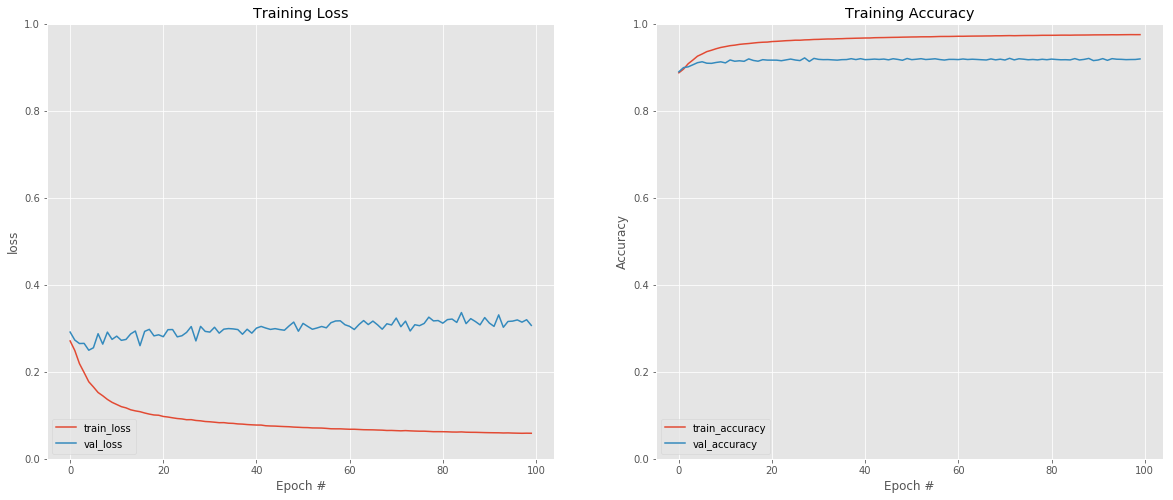

In [50]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

#2nd graph
fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["acc"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("FCN32_result_static_e"+str(num_epochs))
plt.show()

KeyError: 'recall_1'

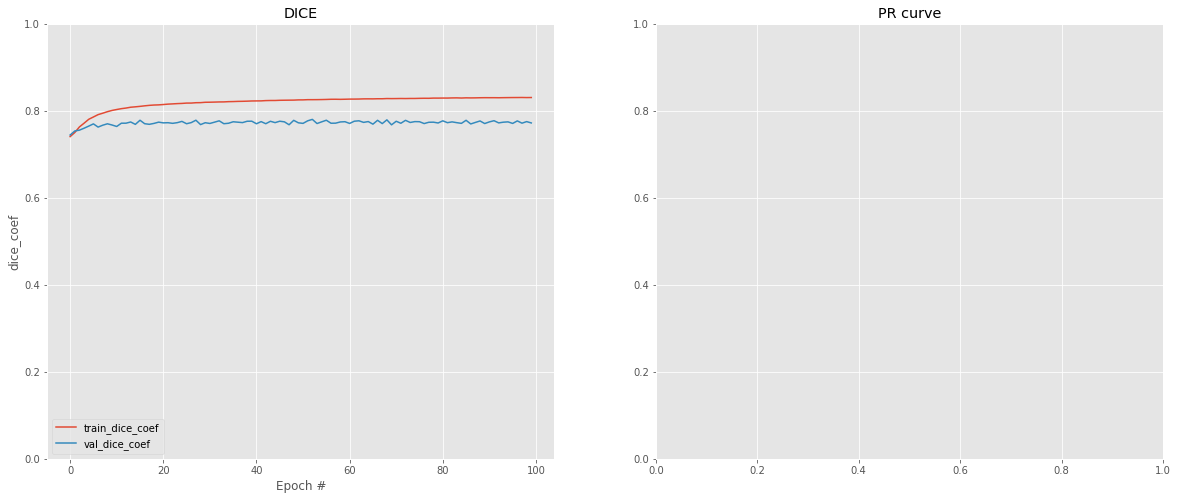

In [51]:
# Get actual number of epochs model was trained for
# N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("DICE")
plt.plot(np.arange(0, N), result.history["dice_coef"], label="train_dice_coef")
plt.plot(np.arange(0, N), result.history["val_dice_coef"], label="val_dice_coef")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("dice_coef")
plt.legend(loc="lower left")

#2nd graph
fig.add_subplot(1,2,2)
plt.title("PR curve")
plt.plot(result.history["recall_1"], result.history["precision_1"], label="train_PR")
plt.plot(result.history["val_recall_1"], result.history["val_precision_1"], label="val_PR")
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.savefig("FCN32_result_static2_e"+str(num_epochs))
plt.show()

In [91]:
#training_gen = TrainAugmentGenerator()
testing_gen = TestAugmentGenerator()

### Extract and display model frame, prediction and mask batch

In [92]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


(10, 224, 224, 32)

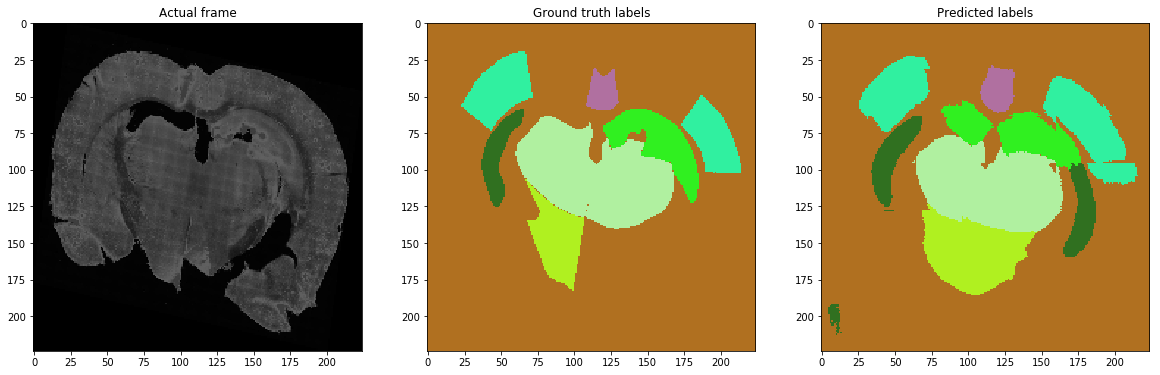

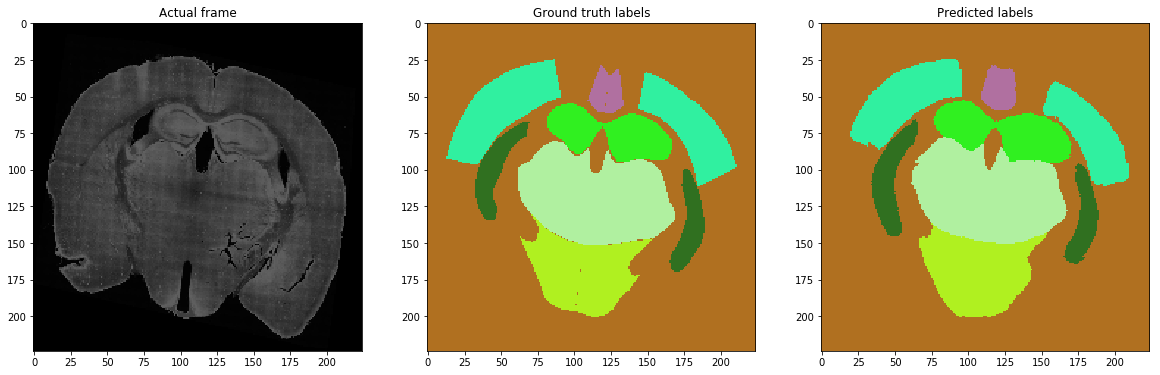

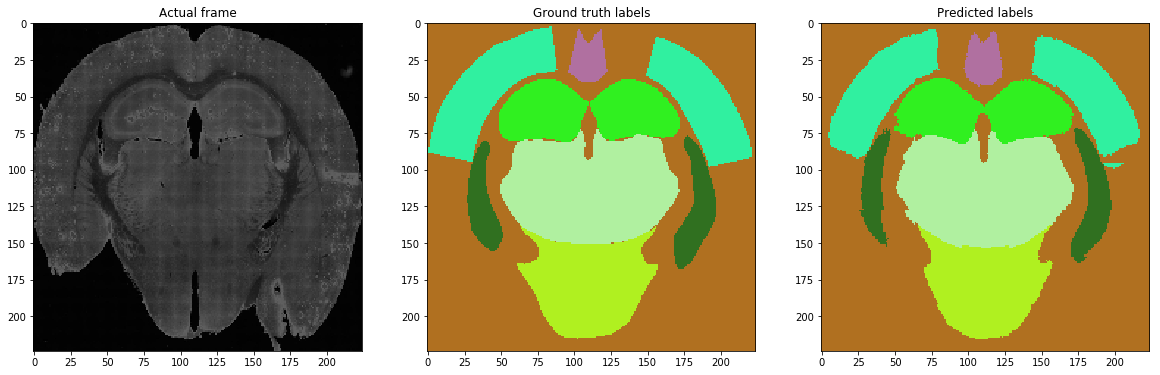

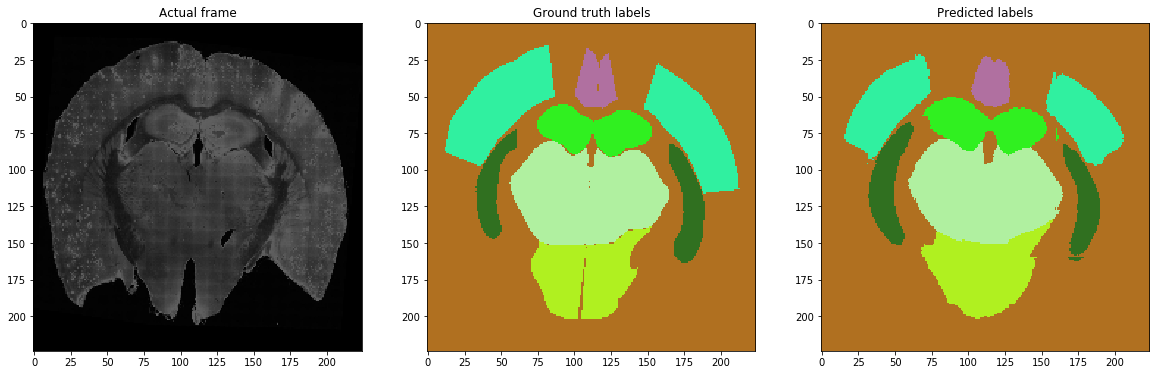

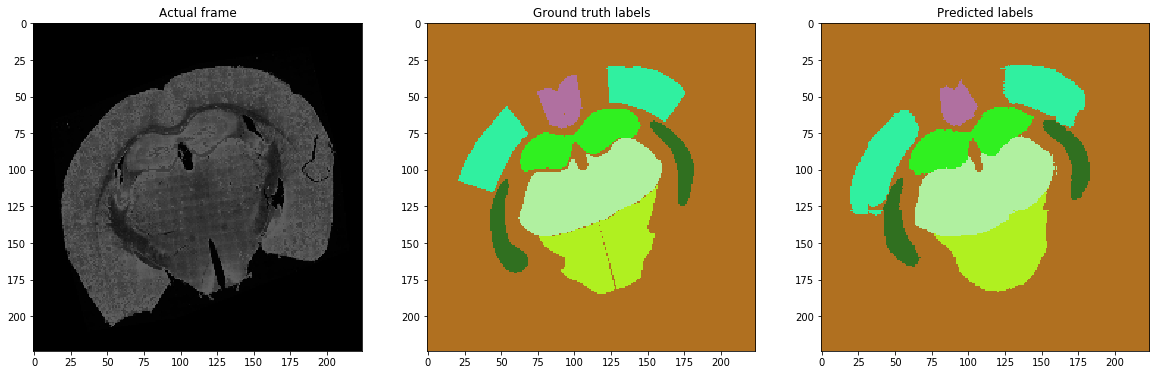

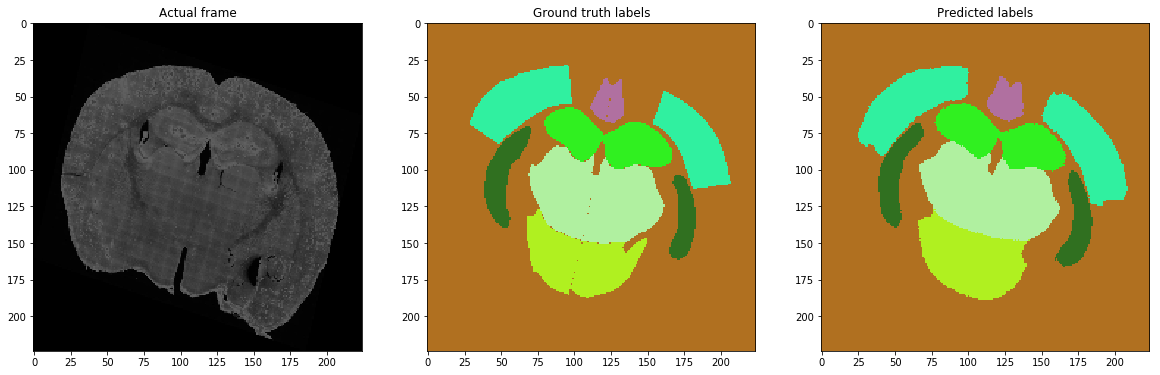

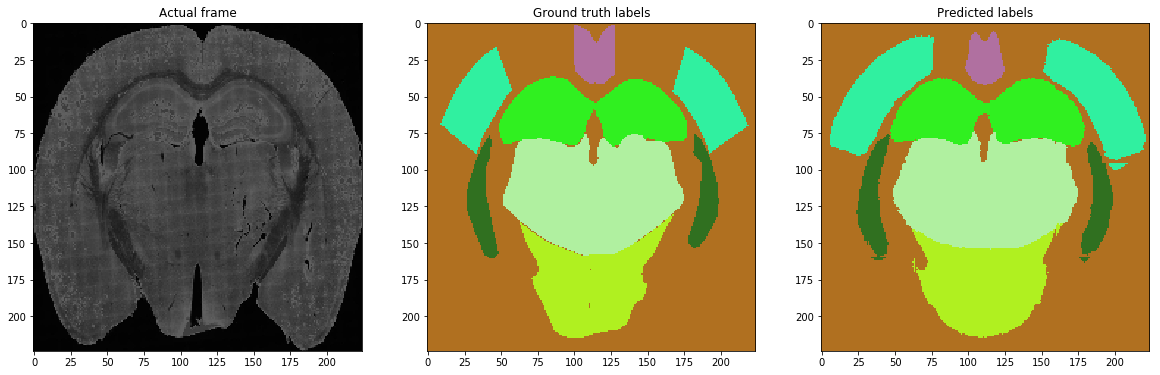

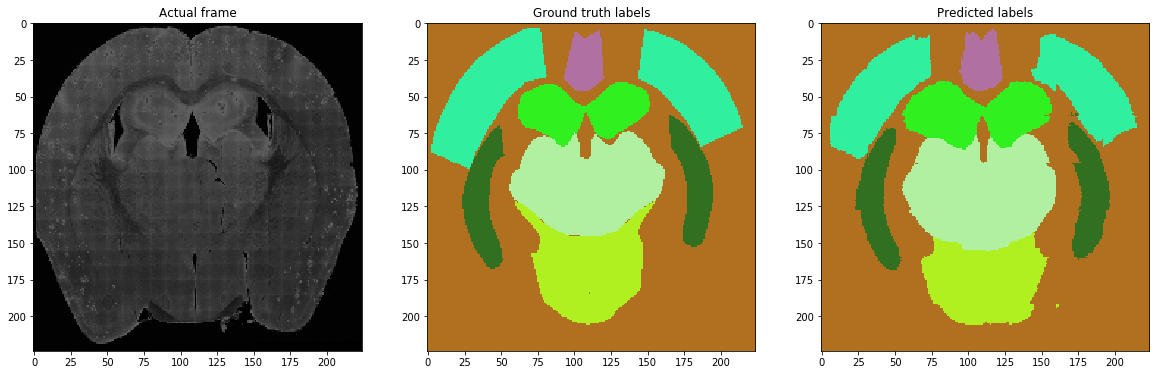

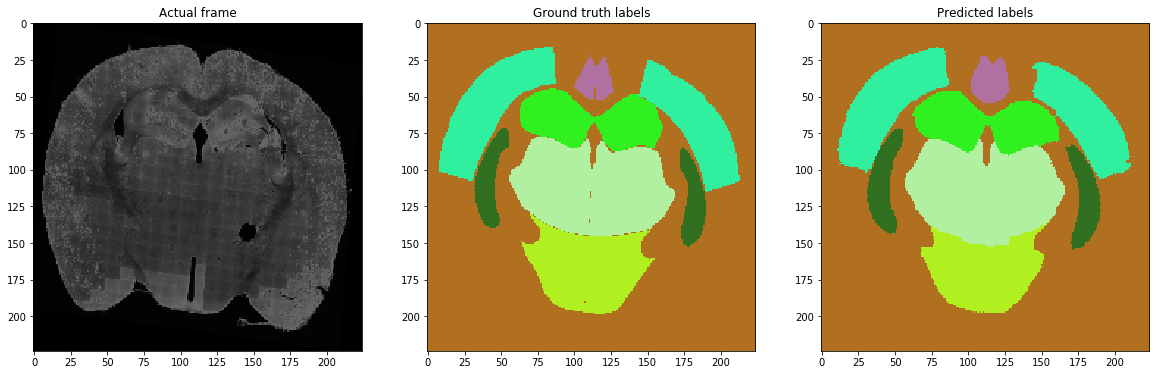

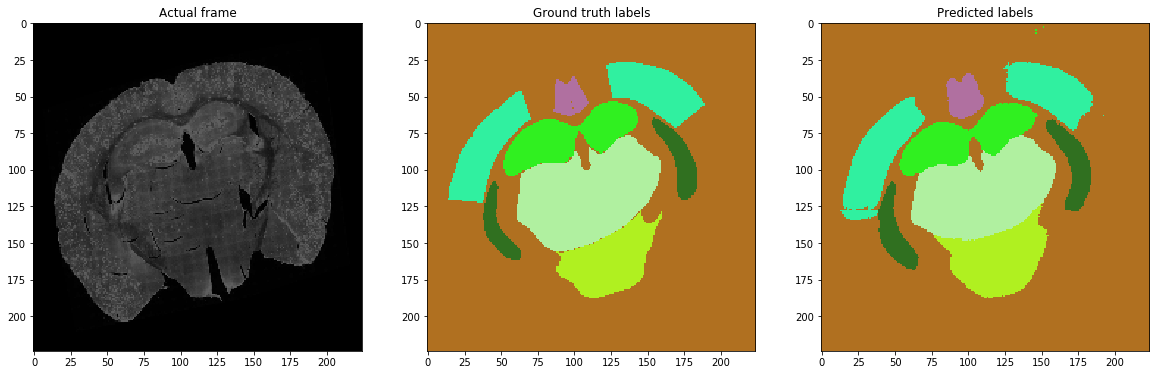

In [93]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    #ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    #ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    #ax3.grid(b=None)
    plt.savefig("FCN32_result_"+str(i))
    plt.show()

In [94]:
model.evaluate(TestAugmentGenerator(), steps=30, batch_size=5)

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
30/30 [==============================] - 37s 1s/step - loss: 0.2302 - tversky_loss: 31.2103 - dice_coef: 0.8228 - recall_1: 0.9051 - precision_1: 0.7313 - iou: 0.6989 - acc: 0.9274


[0.23016123920679094,
 31.21031,
 0.82275456,
 0.90505254,
 0.7312582,
 0.6988814,
 0.9273677]

In [98]:
from sklearn.metrics import classification_report
Y_test = np.argmax(batch_mask, axis=1) # Convert one-hot to index
#y_pred = model.predict_classes(batch_img)
y_pred = model.predict(batch_img)
print(classification_report(Y_test, y_pred))


ValueError: unknown is not supported

In [65]:
from sklearn.metrics import roc_curve

y_pred_keras = model.predict(batch_img).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(batch_mask, y_pred_keras)

ValueError: unknown format is not supported